# BipedalWalker-v2

---
In this notebook, you will implement a TD3 agent with OpenAI Gym's BipedalWalker-v2 environment.


#### 1. Import the Necessary Packages

In [2]:
import torch
import gym
import numpy as np
from collections import deque
from collections import namedtuple
import time
from ReplayBuffer import ReplayBuffer
from Model import TD3
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### 2. Instantiate the Environment
Initialize the environment in the code cell below.

In [3]:
env_name = 'BipedalWalker-v2'
#env_name = 'LunarLanderContinuous-v2'
random_seed = 0
save_every = 500            # safe trained models after interval
print_every = 10
score_to_solve = 300.0
directory = "./preTrained/" # save trained models
filename = "TD3_{}_{}".format(env_name, random_seed)
continue_training = False

max_episodes = 20000        # max num of episodes
max_timesteps = 1500        # max timesteps in one episode

exploration_noise = 0.1

In [4]:
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

env.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


c:\users\tobias\appdata\local\conda\conda\envs\openai\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


#### 3. Train the Agent with TD3
Run the code cell below to train the agent from scratch. You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 10, Average Score: -126.86, Max: -107.33, Min: -162.65, Time: 1.51
Episode 20, Average Score: -107.80, Max: -55.58, Min: -127.63, Time: 2.01
Episode 30, Average Score: -113.73, Max: -102.27, Min: -123.65, Time: 2.77
Episode 40, Average Score: -114.57, Max: -98.43, Min: -129.15, Time: 2.04
Episode 50, Average Score: -117.91, Max: -100.52, Min: -130.59, Time: 1.51
Episode 60, Average Score: -115.34, Max: -96.64, Min: -131.71, Time: 2.03
Episode 70, Average Score: -114.30, Max: -99.07, Min: -128.08, Time: 1.41
Episode 80, Average Score: -119.90, Max: -111.10, Min: -138.33, Time: 2.56
Episode 90, Average Score: -119.16, Max: -103.27, Min: -130.48, Time: 3.28
Episode 100, Average Score: -113.18, Max: -99.30, Min: -127.73, Time: 1.65
Episode 110, Average Score: -122.22, Max: -109.77, Min: -133.88, Time: 1.70
Episode 120, Average Score: -115.18, Max: -106.81, Min: -129.88, Time: 2.44
Episode 130, Average Score: -111.52, Max: -101.57, Min: -127.39, Time: 2.11
Episode 140, Average Score

Episode 1120, Average Score: 304.00, Max: 310.39, Min: 296.56, Time: 23.78
Episode 1130, Average Score: 263.07, Max: 311.38, Min: 78.07, Time: 25.37
Episode 1140, Average Score: 259.89, Max: 307.45, Min: -110.93, Time: 26.47
Episode 1150, Average Score: 264.08, Max: 308.22, Min: -83.12, Time: 24.72
Episode 1160, Average Score: 269.02, Max: 308.40, Min: -44.67, Time: 22.80
Episode 1170, Average Score: 303.32, Max: 307.62, Min: 297.61, Time: 23.89
Episode 1180, Average Score: 269.61, Max: 306.39, Min: 83.46, Time: 24.04
Episode 1190, Average Score: 301.82, Max: 308.36, Min: 297.42, Time: 22.80
Episode 1200, Average Score: 304.24, Max: 309.84, Min: 299.80, Time: 21.90
Episode 1210, Average Score: 304.41, Max: 308.89, Min: 300.75, Time: 22.56
Episode 1220, Average Score: 289.97, Max: 309.24, Min: 149.72, Time: 23.27
Episode 1230, Average Score: 304.20, Max: 308.45, Min: 298.66, Time: 23.21
Episode 1240, Average Score: 304.62, Max: 309.77, Min: 300.49, Time: 22.71
Episode 1250, Average Scor

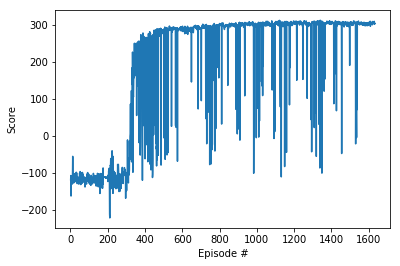

In [7]:
def train():
    policy = TD3(state_dim, action_dim, max_action)
    
    if continue_training:
        policy.load(directory, filename)
    
    replay_buffer = ReplayBuffer()

    scores = []
    avg_reward = 0    
    episode_rewards = []
    
    ep_rewards_deque = deque(maxlen=100)

    for i_episode in range(1, max_episodes+1):
        state = env.reset()
        
        ep_reward = 0
        
        timestep = time.time()
        
        for t in range(max_timesteps):
            # select action and add exploration noise:
            action = policy.select_action(state)
            action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
            action = action.clip(env.action_space.low, env.action_space.high)

            # take action in env:
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add((state, action, reward, next_state, float(done)))
            avg_reward += reward                       
            ep_reward += reward
            state = next_state

            # if i_episode is done then update policy:
            if done or t==(max_timesteps-1):
                policy.update(replay_buffer, t)
                break
                
        episode_rewards.append(ep_reward)
        ep_rewards_deque.append(ep_reward)        
        avg_rewards = (avg_reward / print_every)
        
        if np.mean(ep_rewards_deque) >= score_to_solve:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_rewards))
            policy.save(directory, filename + '_solved')
            break        
        
        if i_episode % print_every == 0:
            min_rewards = np.min(episode_rewards)
            max_rewards = np.max(episode_rewards)            
            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Time: {:.2f}'\
                  .format(i_episode, avg_rewards, max_rewards, min_rewards, time.time() - timestep), end="\n")
            
            avg_reward = 0
            episode_rewards = []
            
        if i_episode % save_every == 0:
            policy.save(directory, filename)
        
        scores.append(ep_reward)
            
    return scores

scores = train()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 4. Watch a Smart Agent!
In the next code cell, you will load the trained weights from file to watch a smart agent!

In [14]:
def test(preTrained=True, max_timesteps=1500):        
    n_episodes = 2    
    
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])    
    
    if preTrained:
        filename = "TD3_{}_{}".format(env_name, random_seed)
        filename += '_solved'    
        directory = "./preTrained/"
        policy = TD3(state_dim, action_dim, max_action)    
        policy.load_actor(directory, filename)    
        
    for ep in range(1, n_episodes+1):
        state = env.reset()
        for t in range(max_timesteps):
            if preTrained:
                action = policy.select_action(state)
            else:
                action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            env.render()            
            if done:
                break
            
    env.close()
        
test()    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
